#目录
* [序言](#sec-preamble)
* [Part 0 - 导入、共享功能和通用代码](#sec-0)
    * [Imports](#subsec-imports)
    * [共享功能](#subsec-shared)
    * [公共代码](#subsec-common)
* [Part 1 - 机器学习简介](#sec1)
    * [Part 1.a - 随机森林回归因子](#subsecl-1a)
* [Part 2 - 中间机器学习-缺失值](#sec2)
    * [Part 2.a - 缺失值(Dropping Values)](#subsec-2a)
    * [Part 2.b - 缺失值(Simple Imputation)](#subsec-2b)
    * [Part 2.c - 缺失值(Extended Imputation)](#subsecl-2c) - Extended(扩展)
* [Part 3 - 中间机器学习-分类变量](#sec-3)
    * [Part 3.a - 分类变量(Drop Categorical Variables(删除分类变量))](#subsecl-3a)
    * [Part 3.b - 分类变量(Label Encoding)](#subsec-3b)
    * [Part 3.c - 分类变量(One-Hot Encoding)](#subsec-3c)
* [Part 4 - 中间机器学习-Pipelines(管道)](#secl-4)
* [Part 5 - 中间机器学习-Cross Validation(交叉验证)](#secl-5)
* [Part 6 - 中级机器学习- XGBoost](#secl-6)
    * [Part 6.a - XGBoost(梯度推进)](#subseco-6a)
    * [Part 6.b - XGBoost(参数调优)](#subsec-6b)
* [Part 7 - 数据可视化](#secl-7)
* [Part 8 - 生成提交](#seco-8)

<a id="sec-preamble"></a>
# **Preamble**

这意味着是一个滚动的笔记本，我们分析“房价:高级回归技术”数据集使用技术学习的coursers提供Kaggle。目前已完成以下课程:
1. Python
2. 机器学习入门
3. 中间机器学习
4. 数据可视化

Currently in progress:
1. Pandas

虽然我之前有过这些课程的经验，但我会尽量只更新这些课程中介绍的概念/想法。

## **Goals**

分析的目的是预测每幢房子的销售价值。对于测试集中的给定ID，我们希望预测从训练集中生成的SalePrice值。

## **Notes**

本笔记本在每门课程结束后更新。
* 第1部分中的导入被注释掉，并移动到第0部分的组合部分
* 共享代码(比如读入数据)被consoldate到第0部分
* 最有效的ML方法是使用参数调优的XGBoost方法。结果是0.13719分，占总分的42%。
* 由于课程的顺序，数据可视化将出现在中间ML之后，这没有多大实际意义。原则上，我们将使用数据可视化来执行特性探索，并确定哪些属性与分析相关。

<a id="sec-0"></a>
# **Part 0. Imports, Shared Functions and Common Code**

After finishing the intermediate course it became clear that having a combined section for imports and any shared functions would be best

在完成中级课程之后，很明显，为导入和任何共享函数组合一个部分是最好的

<a id="subsec-imports"></a>
## Imports

In [1]:
# Imports used throughout the notebook

# plotting packages
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# packages needed for introductory ML

import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# packages needed for intermediate ML

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

# Others
import numpy as np

print("Finished Imports")

Finished Imports


<a id="subsec-shared"></a>
## Shared Functions

In [2]:
def get_MAE(X_train, X_valid, y_train, y_valid):
    """
    Calculates the mean absolute error (MAE) for a ML approach
    为ML方法计算平均绝对误差(MAE)
    
    Input
    -----
    X_train:
        the training data used
    X_valid:
        the data to be compared to
    y_train:
        the y values that are used for training the model
    y_valid:
        the y values we want our comparison to be tested against
    
    Output:
    -------
    mean_absolute_error:
        sum of total absolute error divided by sample size
        总绝对误差除以样本容量的总和
    """
    
    model = RandomForestRegressor(n_estimators=100)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_valid)
    mae = mean_absolute_error(y_valid, y_predict)
    return mae

def get_score(n_estimators, X, y):
    """
    Return the average MAE over 3 CV folds of random forest model.
    
    Input
    -----
    n_estimators:
        the number of trees in the forest
        森林中树木的数量
        
    Output:
    -------
    mean_score:
        The mean scores when using a pipeline to determine the mean absolute error
        使用管道确定平均绝对误差时的平均分数
    """
    # Replace this body with your own code
    pipeline = Pipeline(steps=[('preprocessor', SimpleImputer()),
                               ('model', RandomForestRegressor(n_estimators, random_state=0))])
    scores = -1 * cross_val_score(pipeline, X, y, cv=3, scoring='neg_mean_absolute_error')
    return scores.mean()

def gen_prediction(training_data, target_data, test_data, estimators=100):
    """
    Calculate the model prediction using an inputted training, target and
    test data.

    Input
    -----
    training_data:
        training data in a pandas array used to generate a model
    target_data:
        target data in a pandas array used to generate a model
    test_data: 
        test data we will be fitting a model to
    
    Output:
    -------
    predictions for test data
    """
    # Define and fit model
    my_model = RandomForestRegressor(n_estimators=estimators, random_state=0)
    my_model.fit(training_data, target_data)

    # Get test predictions
    print ("Submission data calculated")
    return my_model.predict(test_data)


<a id="subsec-common"></a>
## Common Code

In [3]:
# Set the paths to our data
test_data_path = "../input/house-prices-advanced-regression-techniques/test.csv"
train_data_path = "../input/house-prices-advanced-regression-techniques/train.csv"
sample_data_path = "../input/house-prices-advanced-regression-techniques/sample_submission.csv"

# Define the data
test_data = pd.read_csv(test_data_path, index_col='Id')
train_data = pd.read_csv(train_data_path, index_col='Id')
sample_data = pd.read_csv(sample_data_path)

# Create a directory to hold the scores of each part with different techniques
scores_dict = {}
submission_dict = {}

print("Data loaded and dictionaries initialized")

Data loaded and dictionaries initialized


### Quick data property checks

In [4]:
# Check the head of each file
test_data.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
train_data.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
sample_data.head(5)

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [7]:
# Output the shape of our test, train, and sample data
print("Training data shape: {}".format(train_data.shape))
print("Testing data shape: {}".format(test_data.shape))
print("Sample data shape: {}".format(sample_data.shape))

Training data shape: (1460, 80)
Testing data shape: (1459, 79)
Sample data shape: (1459, 2)


<a id="sec-1"></a>
# **Part 1. Intro to Machine Learning**
<a id="subsec-1a"></a>
## Part 1.a Using a Random Forest Regressor
* This first submission is unlikely to score very highly as we are only using simple techniques but its a good place to start.
* This submission scored 0.18806 which in the top 79%, we can definitely improve on this score with more advanced analysis.

## Test using Random Forest Regressor
This is the simplest approach, I wont include the attempts using other methods from the intro course

In [8]:
# Define the data for testing
y = train_data.SalePrice
X = train_data.drop(['SalePrice'], axis=1)

# Divide our data into training and validation data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

In [9]:
# Define properties that are useful from the intro course
features = ['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd']
X_train_features = X_train[features]
X_valid_features = X_valid[features]

In [10]:
# Check the MAE of this model
scores_dict['1.a'] = get_MAE(X_train_features, X_valid_features, y_train, y_valid)

print("MAE of simple Random Forest Regressor: ")
print(scores_dict['1.a'])

MAE of simple Random Forest Regressor: 
23523.98780593607


## Generate the Submission using Random Forest Regressor

In [11]:
# Create a target object
train_y = train_data.SalePrice

# Define properties that are useful from the intro course
features = ['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd']
train_X = train_data[features]
test_X = test_data[features]

In [12]:
# Make a prediction on the values using RandomForestRegressor
test_prediction_1a = gen_prediction(train_X, train_y, test_X)

Submission data calculated


In [13]:
# Combine the data together into an output and save it to submission.csv
output = pd.DataFrame({'Id': test_X.index,
                       'SalePrice': test_prediction_1a})
submission_dict['1.a'] = test_prediction_1a
print("Random Forest Regressor Submission Saved")

Random Forest Regressor Submission Saved


<a id="sec-2"></a>
# **Part 2.Intermediate Machine Learning - Missing Data**
* This section will contain predictions done using the techniques taught in the missing data portion intermediate machine learning course
* The score using these techniques was 0.14855 which is in the top 58%

In [14]:
# Define the data that will be used for all tests
y = train_data.SalePrice
X_full = train_data.drop(['SalePrice'], axis=1)

# To keep things simple, we'll use only numerical predictors
X = X_full.select_dtypes(exclude=['object'])

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

# Define the data that will be used for all submission generation
X_test = test_data.select_dtypes(exclude=['object'])

<a id="subsec-2a"></a>
## Part 2.a Missing Values (Dropping values)
This section will use the approach where we simply drop any columns missing data
## Test the effectiveness of dropping values

In [15]:
# Check for missing values in each column of training data
missing_val_train = [column for column in X_train.columns
                     if X_train[column].isnull().any()]
print(missing_val_train)

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']


In [16]:
# drop columns in training and validation data
reduced_X_train = X_train.drop(missing_val_train, axis=1)
reduced_X_valid = X_valid.drop(missing_val_train, axis=1)

In [17]:
# Check the MAE of this model
scores_dict['2.a'] = get_MAE(reduced_X_train, reduced_X_valid, y_train, y_valid)

print("MAE (Drop columns with missing values):")
print(scores_dict['2.a'])

MAE (Drop columns with missing values):
17560.328025114155


## Generate the submission dropping missing values

In [18]:
# Check for missing values in each column of training data and test data using list comprehension
missing_val_X = [column for column in X.columns
                 if X[column].isnull().any()]

missing_val_X_test = [column for column in X_train.columns
                      if X_test[column].isnull().any()]

print("Columns with missing training data: ")
print(missing_val_X)

print("\nColumns with missing test data: ")
print(missing_val_X_test)

Columns with missing training data: 
['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

Columns with missing test data: 
['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea']


In [19]:
# Combine the two sets of missing columns together
# If we combine the two sets of missing columns together arbitrarily we'll get duplicates
print(missing_val_X + missing_val_X_test)

combined_missing_val = list(set(missing_val_X + missing_val_X_test))
print(combined_missing_val)

print("\nTotal number of columns to be dropped:")
print(len(combined_missing_val))

['LotFrontage', 'MasVnrArea', 'GarageYrBlt', 'LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea']
['GarageCars', 'GarageYrBlt', 'LotFrontage', 'BsmtFinSF2', 'TotalBsmtSF', 'BsmtFinSF1', 'BsmtUnfSF', 'GarageArea', 'BsmtHalfBath', 'BsmtFullBath', 'MasVnrArea']

Total number of columns to be dropped:
11


In [20]:
# Drop the missing values in both sets
X_drop = X.drop(combined_missing_val, axis=1)
X_test_drop = X_test.drop(combined_missing_val, axis=1)

print ("Shape of X_train: {}".format(X.shape))
print ("Shape of X_test: {}".format(X_test.shape))

print ("Shape of X_train_drop: {}".format(X_drop.shape))
print ("Shape of X_test_drop: {}".format(X_test_drop.shape))

Shape of X_train: (1460, 36)
Shape of X_test: (1459, 36)
Shape of X_train_drop: (1460, 25)
Shape of X_test_drop: (1459, 25)


In [21]:
# Generate the predictions
test_prediction_2a = gen_prediction(X_drop, y, X_test_drop)

Submission data calculated


In [22]:
# Combine the data together into an output and save it to submission.csv
output = pd.DataFrame({'Id': test_X.index,
                       'SalePrice': test_prediction_2a})
submission_dict['2.a'] = test_prediction_2a
print("Drop Value Submission Saved")

Drop Value Submission Saved


<a id="subsec-2b"></a>
## Part 2.b Missing Values (Simple Imputation)
This section will use the approach where we use imputation to fill in missing data
## Test the effectiveness of simple imputation

In [23]:
# Imputation, setup the simple imputer and apply it to our training data
my_imputer = SimpleImputer()
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train))
imputed_X_valid = pd.DataFrame(my_imputer.transform(X_valid))

# imputation removed column names; put them back
imputed_X_train.columns = X_train.columns
imputed_X_valid.columns = X_valid.columns

In [24]:
# Check the MAE of this model
scores_dict['2.b'] = get_MAE(imputed_X_train, imputed_X_valid, y_train, y_valid)

print("MAE (Imputation):")
print(scores_dict['2.b'])

MAE (Imputation):
18116.185490867574


## Generate the output for simple imputation

In [25]:
# Imputation, setup the simple imputer and apply it to our full data
my_imputer = SimpleImputer()
imputed_X = pd.DataFrame(my_imputer.fit_transform(X))
imputed_X_test = pd.DataFrame(my_imputer.transform(X_test))

# imputation removed column names; put them back
imputed_X.columns = X.columns
imputed_X_test.columns = X_test.columns

In [26]:
# Generate the predictions
test_prediction_2b = gen_prediction(imputed_X, y, imputed_X_test)

Submission data calculated


In [27]:
# Combine the data together into an output and save it to submission.csv
output = pd.DataFrame({'Id': test_X.index,
                       'SalePrice': test_prediction_2b})
submission_dict['2.b'] = test_prediction_2b
print("Simple Imputation Submission Saved")

Simple Imputation Submission Saved


<a id="subsec-2c"></a>
## Part 2.c Missing Values (Extended Imputation)
In this section we will try to extend the simple imputation by only working on the columns with missing data
## Test the effectiveness of extended imputation

In [28]:
# hard copy the data to ensure that we don't change the original
X_train_ext = X_train.copy()
X_valid_ext = X_valid.copy()

# Use the missing columns found in section 2.a, reminder of how these
# columns were found
# missing_column = [col for col in X_train.columns
#                   if X_train[col].isnull().any()]

# generate new columns we want to impute
for column in missing_val_train:
    X_train_ext[column + '_missing'] = X_train_ext[column].isnull()
    X_valid_ext[column + '_missing'] = X_valid_ext[column].isnull()
    
# impute the extended data
# Imputation, setup the simple imputer and apply it to our full data
my_imputer = SimpleImputer()
imputed_X_train_ext = pd.DataFrame(my_imputer.fit_transform(X_train_ext))
imputed_X_valid_ext = pd.DataFrame(my_imputer.transform(X_valid_ext))

# imputation removed column names; put them back
imputed_X_train_ext.columns = X_train_ext.columns
imputed_X_valid_ext.columns = X_valid_ext.columns

In [29]:
# Check the MAE of this model
scores_dict['2.c'] = get_MAE(imputed_X_train_ext, imputed_X_valid_ext, y_train, y_valid)

print("MAE (Extended Imputation):")
print(scores_dict['2.c'])

MAE (Extended Imputation):
18072.668013698632


## Generate the output for extended imputation

In [30]:
# hard copy the data to ensure that we don't change the original
X_ext = X.copy()
X_test_ext = X_test.copy()

# Use the missing columns found in section 2.a, reminder of how these
# columns were found
# missing_column = [col for col in X_train.columns
#                   if X_train[col].isnull().any()]

# generate new columns we want to impute
for column in combined_missing_val:
    X_ext[column + '_missing'] = X_ext[column].isnull()
    X_test_ext[column + '_missing'] = X_test_ext[column].isnull()
    
# impute the extended data
# Imputation, setup the simple imputer and apply it to our full data
my_imputer = SimpleImputer()
imputed_X_ext = pd.DataFrame(my_imputer.fit_transform(X_ext))
imputed_X_test_ext = pd.DataFrame(my_imputer.transform(X_test_ext))

# imputation removed column names; put them back
imputed_X_ext.columns = X_ext.columns
imputed_X_test_ext.columns = X_test_ext.columns

In [31]:
# Generate the predictions
test_prediction_2c = gen_prediction(imputed_X_ext, y, imputed_X_test_ext)

Submission data calculated


In [32]:
# Combine the data together into an output and save it to submission.csv
output = pd.DataFrame({'Id': test_X.index,
                       'SalePrice': test_prediction_2c})
submission_dict['2.c'] = test_prediction_2c
print("Extended Imputation Submission Saved")

Extended Imputation Submission Saved


<a id="sec-3"></a>
# **Part 3. Intermediate Machine Learning - Categorical Variables**
This section will contain predictions done using the techniques taught in the intermediate machine learning course in regards to dealing with categorical variables

In [33]:
# Define the data that will be used for all tests
y = train_data.SalePrice
X = train_data.drop(['SalePrice'], axis=1)

# Define the data that will be used for all submission generation
X_test = test_data.copy()

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      train_size=0.8, test_size=0.2,
                                                      random_state=0)

<a id="subsec-3a"></a>
## Part 3.a Categorical Variables (Drop Categorical Variables)
This section will use the approach where we just drop categorical variables
## Test the effectiveness of dropping variables


In [34]:
# Check for missing values in each column of training data
missing_val_train = [column for column in X_train.columns
                     if X_train[column].isnull().any()]

# drop columns in training and validation data
reduced_X_train = X_train.drop(missing_val_train, axis=1)
reduced_X_valid = X_valid.drop(missing_val_train, axis=1)

In [35]:
print ("Shape of X_train: {}".format(X_train.shape))
print ("Shape of X_valid: {}".format(X_valid.shape))

print ("Shape of reduced_X_train: {}".format(reduced_X_train.shape))
print ("Shape of reduced_X_valid: {}".format(reduced_X_valid.shape))

Shape of X_train: (1168, 79)
Shape of X_valid: (292, 79)
Shape of reduced_X_train: (1168, 60)
Shape of reduced_X_valid: (292, 60)


In [36]:
# Drop the objects from our dataset
drop_X_train = reduced_X_train.select_dtypes(exclude=['object'])
drop_X_valid = reduced_X_valid.select_dtypes(exclude=['object'])

In [37]:
print ("Shape of drop_X_train: {}".format(drop_X_train.shape))
print ("Shape of drop_X_valid: {}".format(drop_X_valid.shape))

Shape of drop_X_train: (1168, 33)
Shape of drop_X_valid: (292, 33)


In [38]:
# Check the MAE of this model
scores_dict['3.a'] = get_MAE(drop_X_train, drop_X_valid, y_train, y_valid)

print("MAE (Drop categorical variables):")
print(scores_dict['3.a'])

MAE (Drop categorical variables):
17780.382191780824


## Generate the output for dropping variables

In [39]:
# Check for missing values in each column of training data and test data using list comprehension
# This is taken from section 2.a for finding columns with missing data
missing_val_X = [column for column in X.columns
                 if X[column].isnull().any()]

missing_val_X_test = [column for column in X_train.columns
                      if X_test[column].isnull().any()]

combined_missing_val = list(set(missing_val_X + missing_val_X_test))

In [40]:
# drop columns in training and validation data
reduced_X = X.drop(combined_missing_val, axis=1)
reduced_X_test = X_test.drop(combined_missing_val, axis=1)

In [41]:
print ("Shape of X: {}".format(X.shape))
print ("Shape of X_test: {}".format(X_test.shape))

print ("Shape of reduced_X: {}".format(reduced_X.shape))
print ("Shape of reduced_X_test: {}".format(reduced_X_test.shape))

Shape of X: (1460, 79)
Shape of X_test: (1459, 79)
Shape of reduced_X: (1460, 45)
Shape of reduced_X_test: (1459, 45)


In [42]:
# Drop the objects from our dataset
drop_X = reduced_X.select_dtypes(exclude=['object'])
drop_X_test = reduced_X_test.select_dtypes(exclude=['object'])

In [43]:
print ("Shape of drop_X: {}".format(drop_X.shape))
print ("Shape of drop_X_test: {}".format(drop_X_test.shape))

Shape of drop_X: (1460, 25)
Shape of drop_X_test: (1459, 25)


In [44]:
# Generate the predictions
test_prediction_3a = gen_prediction(drop_X, y, drop_X_test)

Submission data calculated


In [45]:
# Combine the data together into an output and save it to submission.csv
output = pd.DataFrame({'Id': test_X.index,
                       'SalePrice': test_prediction_3a})
submission_dict['3.a'] = test_prediction_3a
print("Drop Variable Submission Saved")

Drop Variable Submission Saved


<a id="subsec-3b"></a>
## Part 3.b Categorical Variables (Label Encoding)
This section will use the approach where we assign a unique value to a different integer
## Test the effectiveness of converting labels to integer values

In [46]:
# All categorical columns
object_cols = [column for column in X_train.columns if
               X_train[column].dtype == "object"]

# Columns that can be safely label encoded
good_label_cols = [column for column in object_cols if 
                   set(X_train[column]) == set(X_valid[column])]
        
# Problematic columns that will be dropped from the dataset
bad_label_cols = list(set(object_cols) - set(good_label_cols))
        
print('Categorical columns that will be label encoded:', good_label_cols)
print('\nCategorical columns that will be dropped from the dataset:', bad_label_cols)

Categorical columns that will be label encoded: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'BldgType', 'HouseStyle', 'MasVnrType', 'ExterQual', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'CentralAir', 'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'SaleCondition']

Categorical columns that will be dropped from the dataset: ['LandSlope', 'Exterior1st', 'SaleType', 'RoofMatl', 'Condition1', 'RoofStyle', 'GarageQual', 'Functional', 'HeatingQC', 'Neighborhood', 'Utilities', 'Heating', 'BsmtCond', 'Condition2', 'MiscFeature', 'GarageType', 'Exterior2nd', 'Foundation', 'ExterCond', 'Electrical']


In [47]:
# Drop categorical columns that will not be encoded
label_X_train = X_train.drop(bad_label_cols, axis=1)
label_X_valid = X_valid.drop(bad_label_cols, axis=1)

print ("Shape of X_train: {}".format(X_train.shape))
print ("Shape of X_valid: {}".format(X_valid.shape))

print ("\nShape of label_X_train after dropping bad labels: {}".format(label_X_train.shape))
print ("Shape of label_X_valid after dropping bad labels: {}".format(label_X_valid.shape))

Shape of X_train: (1168, 79)
Shape of X_valid: (292, 79)

Shape of label_X_train after dropping bad labels: (1168, 59)
Shape of label_X_valid after dropping bad labels: (292, 59)


In [48]:
# Apply label encoder 
# Cannot use the code shown in the course, will raise error:
#     TypeError: Encoders require their input to be uniformly strings or numbers. Got ['float', 'str']
# For solution:
#     https://stackoverflow.com/questions/46406720/labelencoder-typeerror-not-supported-between-instances-of-float-and-str

label_encoder = LabelEncoder()
for column in set(good_label_cols):
    label_X_train[column] = label_encoder.fit_transform(X_train[column].astype(str))
    label_X_valid[column] = label_encoder.transform(X_valid[column].astype(str))

In [49]:
# We cant directly calculate the MAE from this point,
# if we do there will be some missing values, need to impute some values
imputed_label_X_train = pd.DataFrame(my_imputer.fit_transform(label_X_train))
imputed_label_X_valid = pd.DataFrame(my_imputer.transform(label_X_valid))

# imputation removed column names; put them back
imputed_label_X_train.columns = label_X_train.columns
imputed_label_X_valid.columns = label_X_valid.columns

In [50]:
# Check the MAE of this model
scores_dict['3.b'] = get_MAE(imputed_label_X_train, imputed_label_X_valid, y_train, y_valid)

print("MAE (Label Encoding):") 
print(scores_dict['3.b'])

MAE (Label Encoding):
17613.571061643837


## Generate the output for label encoding

If we directly follow the same steps as above for calculating the MAE we encounter an error where there are remaining NaN in the data set. To solve this we need to split the data into categorical and numerical data and work with them separately. Once we have processed the data in two chunks we can concat them back together then generate the predictions.


In [51]:
# All categorical columns
object_cols_full = X.columns

# Columns that can be safely label encoded
good_label_cols_full = [column for column in object_cols_full if 
                        set(X[column]) == set(X_test[column])]
        
# Problematic columns that will be dropped from the dataset
bad_label_cols_full = list(set(object_cols_full) - set(good_label_cols_full))

print('\nNumber of Categorical columns that will be label encoded:', len(good_label_cols_full))
print('Categorical columns that will be label encoded:', good_label_cols_full)

print('\nNumber of categorical columns that will be dropped from the dataset:', len(bad_label_cols_full))
print('Categorical columns that will be dropped from the dataset:', bad_label_cols_full)


Number of Categorical columns that will be label encoded: 34
Categorical columns that will be label encoded: ['Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'OverallQual', 'OverallCond', 'YearRemodAdd', 'RoofStyle', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir', 'HalfBath', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCond', 'PavedDrive', 'Fence', 'MoSold', 'YrSold', 'SaleCondition']

Number of categorical columns that will be dropped from the dataset: 45
Categorical columns that will be dropped from the dataset: ['GrLivArea', 'LotFrontage', '2ndFlrSF', 'Exterior1st', 'SaleType', 'Fireplaces', 'OpenPorchSF', 'RoofMatl', 'MSSubClass', 'ScreenPorch', 'EnclosedPorch', '1stFlrSF', 'BsmtFinSF1', 'GarageQual', 'Functional', 'LotArea', 'GarageCars', 'Utilities', 'YearBuilt', 'BsmtHalfBath', 'MasVnrArea', 'Heating',

In [52]:
# Separate the categorical columns and numeric columns
cat_X = X[object_cols_full].copy()
cat_X_test = X_test[object_cols_full].copy()

num_X = X.select_dtypes(exclude=['object']).copy()

num_X_test = X_test.select_dtypes(exclude=['object']).copy()

# Drop categorical columns that will not be encoded
label_cat_X = cat_X.drop(bad_label_cols_full, axis=1)
label_cat_X_test = cat_X_test.drop(bad_label_cols_full, axis=1)

In [53]:
print ("Shape of X: {}".format(X.shape))
print ("Shape of X_test: {}".format(X_test.shape))

print ("\nShape of cat_X: {}".format(cat_X.shape))
print ("Shape of cat_X_test: {}".format(cat_X_test.shape))

print ("\nShape of num_X: {}".format(num_X.shape))
print ("Shape of num_X_test: {}".format(num_X_test.shape))

print ("\nShape of label_cat_X after dropping bad labels: {}".format(label_cat_X.shape))
print ("Shape of label_cat_X_test after dropping bad labels: {}".format(label_cat_X_test.shape))

Shape of X: (1460, 79)
Shape of X_test: (1459, 79)

Shape of cat_X: (1460, 79)
Shape of cat_X_test: (1459, 79)

Shape of num_X: (1460, 36)
Shape of num_X_test: (1459, 36)

Shape of label_cat_X after dropping bad labels: (1460, 34)
Shape of label_cat_X_test after dropping bad labels: (1459, 34)


In [54]:
# Impute the two different sets of data:

# Impute numerical columns
num_imputer = SimpleImputer(strategy='mean')

imputed_num_X = pd.DataFrame(num_imputer.fit_transform(num_X))
imputed_num_X_test = pd.DataFrame(num_imputer.transform(num_X_test))

# imputation removed column names; put them back
imputed_num_X.columns = num_X.columns
imputed_num_X_test.columns = num_X_test.columns

In [55]:
# Impute category columns
cat_imputer = SimpleImputer(strategy='most_frequent')

imputed_label_cat_X = pd.DataFrame(cat_imputer.fit_transform(label_cat_X))
imputed_label_cat_X_test = pd.DataFrame(cat_imputer.transform(label_cat_X_test))

# imputation removed column names; put them back
imputed_label_cat_X.columns = label_cat_X.columns
imputed_label_cat_X_test.columns = label_cat_X_test.columns

In [56]:
# Apply label encoder 
# Cannot use the code shown in the course, will raise error:
#     TypeError: Encoders require their input to be uniformly strings or numbers. Got ['float', 'str']
# For solution:
#     https://stackoverflow.com/questions/46406720/labelencoder-typeerror-not-supported-between-instances-of-float-and-str

label_encoder = LabelEncoder()
for column in set(good_label_cols_full):
    imputed_label_cat_X[column] = label_encoder.fit_transform(X[column].astype(str))
    imputed_label_cat_X_test[column] = label_encoder.transform(X_test[column].astype(str))

In [57]:
print ("\nShape of imputed_label_cat_X: {}".format(imputed_label_cat_X.shape))
print ("Shape of imputed_label_cat_X_test: {}".format(imputed_label_cat_X_test.shape))


Shape of imputed_label_cat_X: (1460, 34)
Shape of imputed_label_cat_X_test: (1459, 34)


In [58]:
full_label_X = pd.concat([imputed_num_X, imputed_label_cat_X], axis=1)
full_label_X_test = pd.concat([imputed_num_X_test, imputed_label_cat_X_test], axis=1)

print ("\nShape of full_label_X after merge: {}".format(full_label_X.shape))
print ("Shape of full_label_X_test after merge: {}".format(full_label_X_test.shape))


Shape of full_label_X after merge: (1460, 70)
Shape of full_label_X_test after merge: (1459, 70)


In [59]:
# Generate the predictions
test_prediction_3b = gen_prediction(full_label_X, y, full_label_X_test)

Submission data calculated


In [60]:
# Combine the data together into an output and save it to submission.csv
output = pd.DataFrame({'Id': test_X.index,
                       'SalePrice': test_prediction_3b})
submission_dict['3.b'] = test_prediction_3b
print("Label Variable Submission Saved")

Label Variable Submission Saved


<a id="subsec-3c"></a>
## Part 3.c Categorical Variables (One-Hot Encoding)
Here we will use one-hot encoding where we create new columns that indicate the presence or absence of values in the original data.
## Testing One-Hot Encoding

In [61]:
# Investigate cardinality
object_cols = [column for column in X_train.columns if X_train[column].dtype == "object"]

# Columns that will be one-hot encoded
low_cardinality_cols = [column for column in object_cols if X_train[column].nunique() < 10]

# Columns that will be dropped from the dataset
high_cardinality_cols = list(set(object_cols)-set(low_cardinality_cols))

print('Categorical columns that will be one-hot encoded:', low_cardinality_cols)
print('\nCategorical columns that will be dropped from the dataset:', high_cardinality_cols)

OH_X_train = X_train[low_cardinality_cols]
OH_X_valid = X_valid[low_cardinality_cols]

Categorical columns that will be one-hot encoded: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']

Categorical columns that will be dropped from the dataset: ['Exterior1st', 'Neighborhood', 'Exterior2nd']


In [62]:
# Imputation to categorical columns or we'll encounter problems with NaN
# Impute category columns
cat_imputer = SimpleImputer(strategy='most_frequent')

imputed_X_train = pd.DataFrame(cat_imputer.fit_transform(OH_X_train))
imputed_X_valid = pd.DataFrame(cat_imputer.transform(OH_X_valid))

# imputation removed column names; put them back
imputed_X_train.columns = OH_X_train.columns
imputed_X_valid.columns = OH_X_valid.columns


In [63]:
# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)

In [64]:
# Impute numerical columns
num_imputer = SimpleImputer(strategy='mean')

imputed_num_X_train = pd.DataFrame(num_imputer.fit_transform(num_X_train))
imputed_num_X_valid = pd.DataFrame(num_imputer.transform(num_X_valid))

# imputation removed column names; put them back
imputed_num_X_train.columns = num_X_train.columns
imputed_num_X_valid.columns = num_X_valid.columns

In [65]:
# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(imputed_X_train))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(imputed_X_valid))

# One-hot encoding removed index; put it back
OH_cols_train.index = imputed_X_train.index
OH_cols_valid.index = imputed_X_valid.index

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([OH_cols_train, imputed_num_X_train], axis=1)
OH_X_valid = pd.concat([OH_cols_valid, imputed_num_X_valid], axis=1)

In [66]:
print ("\nShape of num_X_train: {}".format(num_X_train.shape))
print ("Shape of num_X_valid: {}".format(num_X_valid.shape))

print ("\nShape of OH_cols_train: {}".format(OH_cols_train.shape))
print ("Shape of OH_cols_valid: {}".format(OH_cols_valid.shape))

print ("\nShape of OH_X_train after merge: {}".format(OH_X_train.shape))
print ("Shape of OH_X_valid after merge: {}".format(OH_X_valid.shape))


Shape of num_X_train: (1168, 36)
Shape of num_X_valid: (292, 36)

Shape of OH_cols_train: (1168, 191)
Shape of OH_cols_valid: (292, 191)

Shape of OH_X_train after merge: (1168, 227)
Shape of OH_X_valid after merge: (292, 227)


In [67]:
scores_dict['3.c'] = get_MAE(OH_X_train, OH_X_valid, y_train, y_valid)

print("MAE (One-Hot Encoding):") 
print(scores_dict['3.c'])

MAE (One-Hot Encoding):
17612.669006849315


## Generate the output for One Hot Encoding
We can effectively just copy the code for generating the MAE value and change the inputs to take the entire dataset instead.

In [68]:
# Investigate cardinality
object_cols_full = [column for column in X.columns if X[column].dtype == "object"]

# Columns that will be one-hot encoded
low_cardinality_cols_full = [column for column in object_cols_full if X[column].nunique() < 10]

# Columns that will be dropped from the dataset
high_cardinality_cols_full = list(set(object_cols_full)-set(low_cardinality_cols_full))

print('Categorical columns that will be one-hot encoded:', low_cardinality_cols_full)
print('\nCategorical columns that will be dropped from the dataset:', high_cardinality_cols_full)

OH_X = X[low_cardinality_cols_full]
OH_X_test = X_test[low_cardinality_cols_full]

Categorical columns that will be one-hot encoded: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']

Categorical columns that will be dropped from the dataset: ['Exterior1st', 'Neighborhood', 'Exterior2nd']


In [69]:
# Imputation to categorical columns or we'll encounter problems with NaN
# Impute category columns
cat_imputer = SimpleImputer(strategy='most_frequent')

imputed_X = pd.DataFrame(cat_imputer.fit_transform(OH_X))
imputed_X_test = pd.DataFrame(cat_imputer.transform(OH_X_test))

# imputation removed column names; put them back
imputed_X.columns = OH_X.columns
imputed_X_test.columns = OH_X_test.columns


In [70]:
# Remove categorical columns (will replace with one-hot encoding)
num_X = X.drop(object_cols_full, axis=1)
num_X_test = X_test.drop(object_cols_full, axis=1)

In [71]:
# Impute numerical columns
num_imputer = SimpleImputer(strategy='mean')

imputed_num_X = pd.DataFrame(num_imputer.fit_transform(num_X))
imputed_num_X_test = pd.DataFrame(num_imputer.transform(num_X_test))

# imputation removed column names; put them back
imputed_num_X.columns = num_X.columns
imputed_num_X_test.columns = num_X_test.columns

In [72]:
# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols = pd.DataFrame(OH_encoder.fit_transform(imputed_X))
OH_cols_test = pd.DataFrame(OH_encoder.transform(imputed_X_test))

# One-hot encoding removed index; put it back
OH_cols.index = imputed_X.index
OH_cols_test.index = imputed_X_test.index

# Add one-hot encoded columns to numerical features
OH_X = pd.concat([OH_cols, imputed_num_X], axis=1)
OH_X_test = pd.concat([OH_cols_test, imputed_num_X_test], axis=1)

In [73]:
# Generate the predictions
test_prediction_3c = gen_prediction(OH_X, y, OH_X_test)

Submission data calculated


In [74]:
# Combine the data together into an output and save it to submission.csv
output = pd.DataFrame({'Id': test_X.index,
                       'SalePrice': test_prediction_3c})
submission_dict['3.c'] = test_prediction_3c
print("One-Hot Encoding Submission Saved")

One-Hot Encoding Submission Saved


<a id="sec-4"></a>
# Part 4. Intermediate Machine Learning - Pipelines
This section will demonstrate the use of pipelines. Pipelines won't necessarily improve our MAE score but it does bundle the preprocessing and modelling steps together which will streamline our code

In [75]:
# Define the data that will be used for all tests
y_full = train_data.SalePrice
X_full = train_data.drop(['SalePrice'], axis=1)

# Define the data that will be used for all submission generation
X_test_full = test_data.copy()

# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X_full, y, 
                                                                train_size=0.8, test_size=0.2,
                                                                random_state=0)

## Test the effectiveness of pipelines

In [76]:
# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality
categorical_cols = [cname for cname in X_train_full.columns if
                    X_train_full[cname].nunique() < 10 and 
                    X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if 
                X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

In [77]:
# Preprocessing for numerical data
# depending on choice of strategy we can get very different MAE values later
numerical_transformer = SimpleImputer(strategy='mean')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [78]:
# Define model
model = RandomForestRegressor(n_estimators=100, random_state=0)

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

In [79]:
# Preprocessing of training data, fit model 
clf.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = clf.predict(X_valid)

In [80]:
scores_dict['4.a'] = mean_absolute_error(y_valid, preds)

print("MAE (Pipeline):") 
print(scores_dict['4.a'])

MAE (Pipeline):
17648.417157534244


## Generate the output for pipelines

In [81]:
# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols_full = [cname for cname in X.columns if
                         X[cname].nunique() < 10 and 
                         X[cname].dtype == "object"]

# Select numerical columns
numerical_cols_full = [cname for cname in X.columns if 
                       X[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols_full = categorical_cols_full + numerical_cols_full
X = X_full[my_cols_full].copy()
X_test = X_test_full[my_cols_full].copy()

In [82]:
# Preprocessing for numerical data
# depending on choice of strategy we can get very different MAE values later
numerical_transformer = SimpleImputer(strategy='mean')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols_full),
        ('cat', categorical_transformer, categorical_cols_full)
    ])

In [83]:
# Define model
model = RandomForestRegressor(n_estimators=100, random_state=0)

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

In [84]:
# Preprocessing of training data, fit model 
clf.fit(X, y)

# Preprocessing of validation data, get predictions
test_prediction_4 = clf.predict(X_test)

In [85]:
# Combine the data together into an output and save it to submission.csv
output = pd.DataFrame({'Id': test_X.index,
                       'SalePrice': test_prediction_4})
submission_dict['4.a'] = test_prediction_4
print("Pipeline Submission Saved")

Pipeline Submission Saved


<a id="sec-5"></a>
# Part 5. Intermediate Machine Learning - Cross-Validation
Machine learning is iterative and is a better way to validate our data, but it shouldn't lead to a strong result without a solid algorithm to start with. For the test portion of this we will still use the full data set and choose the number of estimators that produces the best result for the submission.

In [86]:
# Define the data that will be used for all tests
y = train_data.SalePrice
X = train_data.drop(['SalePrice'], axis=1)

# Define the data that will be used for all submission generation
X_test = test_data.copy()

## Testing Cross-validation

In [87]:
# Take the column filtering from pipelines
categorical_cols = [cname for cname in X.columns if X[cname].nunique() < 10 and 
                        X[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols

In [88]:
# Filter down to the numerical columns
cv_X = X[numerical_cols].copy()
cv_test = X_test[numerical_cols].copy()

In [89]:
# Generate the results
results={}
for index in range(1, 9):
    results[50*index] = get_score(n_estimators=50*index, X=cv_X, y=y)

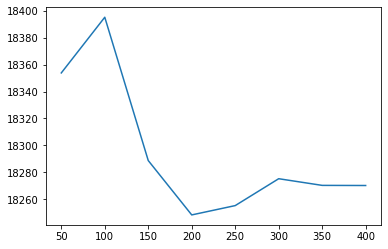

In [90]:
# Plot the results to see where the ideal number of n_estimators is
plt.plot(list(results.keys()), list(results.values()))
plt.show()

In [91]:
min_n_ests = min(results, key=results.get)

print("n_estimators with lowest score:")
print(min_n_ests)

n_estimators with lowest score:
200


In [92]:
scores_dict['5.a'] = min(results.values())

print("MAE (Pipeline):") 
print(scores_dict['5.a'])

MAE (Pipeline):
18248.345889801505


## Generating Submission Using Cross-validation

In [93]:
# create the pipeline
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='mean')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [94]:
# Define the Model with the n_estimators with lowest score
model = RandomForestRegressor(n_estimators=min_n_ests, random_state=0)

In [95]:
# Preprocessing of training data, fit model 
cv_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])
cv_X = X[my_cols].copy()
cv_X_test = X_test[my_cols].copy()
cv_pipeline.fit(cv_X, y)

# Preprocessing of validation data, get predictions
test_prediction_5 = cv_pipeline.predict(cv_X_test)

In [96]:
# Combine the data together into an output and save it to submission.csv
output = pd.DataFrame({'Id': test_X.index,
                       'SalePrice': test_prediction_5})
submission_dict['5.a'] = test_prediction_5
print("Cross Validation Submission Saved")

Cross Validation Submission Saved


<a id="sec-6"></a>
# Part 6. Intermediate Machine Learning - XGBoost
In all of our previous sections we have been using random forest, here we will be using a different method called gradient boosting. This method should yield much better results.

In [97]:
# Define the data that will be used for all tests
y_full = train_data.SalePrice
X_full = train_data.drop(['SalePrice'], axis=1)

# Define the data that will be used for all submission generation
X_test_full = test_data.copy()

# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X_full, y, 
                                                                train_size=0.8, test_size=0.2,
                                                                random_state=0)

<a id="subsec-6a"></a>
## Part 6.a XGBoost (Gradient Boost)
## Testing the effectiveness of Gradient Boost

In [98]:
# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]

# Select numeric columns
numeric_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = low_cardinality_cols + numeric_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

# One-hot encode the data (to shorten the code, we use pandas)
X_train = pd.get_dummies(X_train)
X_valid = pd.get_dummies(X_valid)
X_train, X_valid = X_train.align(X_valid, join='left', axis=1)

In [99]:
# Train model
my_model = XGBRegressor(random_state=0)
my_model.fit(X_train, y_train)
# Predict
prediction_1 = my_model.predict(X_valid)

In [100]:
scores_dict['6.a'] = mean_absolute_error(y_valid, prediction_1)

print("MAE (Gradient Boost):") 
print(scores_dict['6.a'])

MAE (Gradient Boost):
17662.736729452055


## Generating the Submission for Gradient Boost

In [101]:
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
low_cardinality_cols = [cname for cname in X.columns if X[cname].nunique() < 10 and 
                        X[cname].dtype == "object"]

# Select numeric columns
numeric_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = low_cardinality_cols + numeric_cols
X = X_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()

# One-hot encode the data (to shorten the code, we use pandas)
X = pd.get_dummies(X)
X_test = pd.get_dummies(X_test)
X, X_test = X.align(X_test, join='left', axis=1)

In [102]:
my_model = XGBRegressor(random_state=0)
my_model.fit(X, y)
test_prediction_6a = my_model.predict(X_test)

In [103]:
# Combine the data together into an output and save it to submission.csv
output = pd.DataFrame({'Id': test_X.index,
                       'SalePrice': test_prediction_6a})
submission_dict['6.a'] = test_prediction_6a
print("XGBoost Submission Saved")

XGBoost Submission Saved


<a id="subsec-6b"></a>
## Part 6.b XGBoost (Parameter Tuning)
## Testing Parameter Tuning

In [104]:
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]

# Select numeric columns
numeric_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = low_cardinality_cols + numeric_cols

X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()


# One-hot encode the data (to shorten the code, we use pandas)
X_train = pd.get_dummies(X_train)
X_valid = pd.get_dummies(X_valid)
X_train, X_valid = X_train.align(X_valid, join='left', axis=1)

In [105]:
# Define the model
my_model_2 = XGBRegressor(n_estimators=500, learning_rate=0.05)

# Fit the model
my_model_2.fit(X_train, y_train,
               early_stopping_rounds=5,
               eval_set=[(X_valid, y_valid)],
               verbose=False)
               

# Get predictions
prediction_2 = my_model_2.predict(X_valid)

In [106]:
scores_dict['6.b'] = mean_absolute_error(y_valid, prediction_2)

print("MAE (Parameter Tuning):") 
print(scores_dict['6.b'])

MAE (Parameter Tuning):
16802.965325342466


## Generate Submission using Parameter Tuning
Unlike the other methods, parameter tuning requires a training set, a validation set, and a test set

In [107]:
# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]

# Select numeric columns
numeric_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = low_cardinality_cols + numeric_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()


# One-hot encode the data (to shorten the code, we use pandas)
X_train = pd.get_dummies(X_train)
X_valid = pd.get_dummies(X_valid)
X_test = pd.get_dummies(X_test)
X_train, X_valid = X_train.align(X_valid, join='left', axis=1)
X_train, X_test = X_train.align(X_test, join='left', axis=1)

In [108]:
# Define the model
my_model_3 = XGBRegressor(n_estimators=500, learning_rate=0.05)

# Fit the model
my_model_3.fit(X_train, y_train,
               early_stopping_rounds=5,
               eval_set=[(X_valid, y_valid)],
               verbose=False)

test_prediction_6b = my_model_3.predict(X_test)

In [109]:
# Combine the data together into an output and save it to submission.csv
output = pd.DataFrame({'Id': test_X.index,
                       'SalePrice': test_prediction_6b})
submission_dict['6.b'] = test_prediction_6b
print("Parameter Tuning Submission Saved")

Parameter Tuning Submission Saved


<a id="sec-7"></a>
# Part 7. Visualizations
We will plot the housing prices data in a variety of ways to learn more about the dataset.

In [110]:
# Set the paths to our data
test_data_path = "../input/house-prices-advanced-regression-techniques/test.csv"
train_data_path = "../input/house-prices-advanced-regression-techniques/train.csv"
sample_data_path = "../input/house-prices-advanced-regression-techniques/sample_submission.csv"

# Define the data
test_data = pd.read_csv(test_data_path, index_col='Id')
train_data = pd.read_csv(train_data_path, index_col='Id')
sample_data = pd.read_csv(sample_data_path)

# Define the plot style used
sns.set_style("darkgrid")

<a id="subsec-7a"></a>
## Part 7.a Analyzing "SalePrice"
First thing we'll check out is how the main property of SalePrice changes in relation to other properties

In [111]:
# Look at the sale price using the describe function
train_data['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

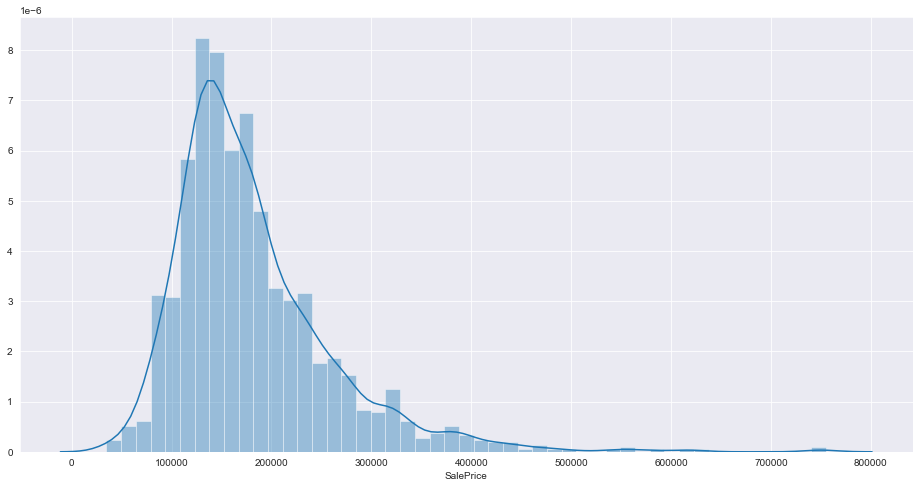

In [112]:
# Look at the sale price visually using a histogram
plt.figure(figsize=(16, 8))
sns.distplot(train_data['SalePrice'])

It looks like the SalePrice is strongly peaked at ~15000 with a longer tail towards higher prices.

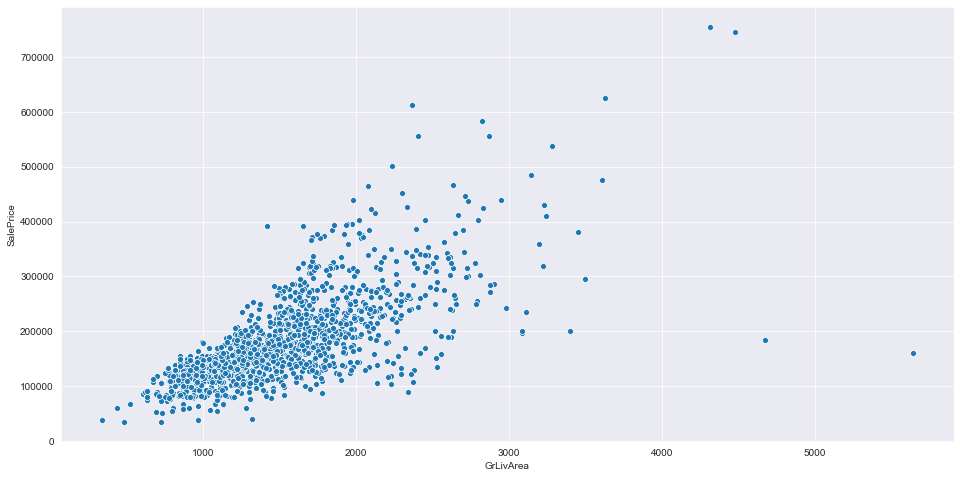

In [113]:
# The documentation states that there are potential outliers in comparing
# SalePrice and GrLivArea (Above grade (ground) living area square feet)
# so lets see if that is true

plt.figure(figsize=(16,8))
sns.scatterplot(x=train_data['GrLivArea'], y=train_data['SalePrice'])

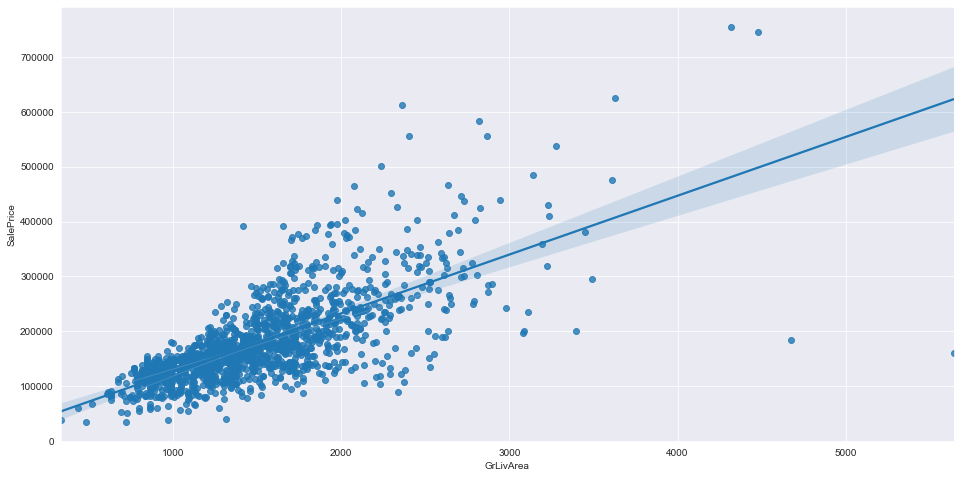

In [114]:
# There are some pretty extreme outliers out beyond GrLivArea > 4000 with SalePrice < 20000
# Lets draw trend lines with these points and without to see their effect

plt.figure(figsize=(16,8))
sns.regplot(x=train_data['GrLivArea'], y=train_data['SalePrice'])

high GrLivArea points:  [ 523  691 1182 1298]

low SalePrice points:  [   1    3    5 ... 1455 1458 1459]

outliers:  [523, 1298]


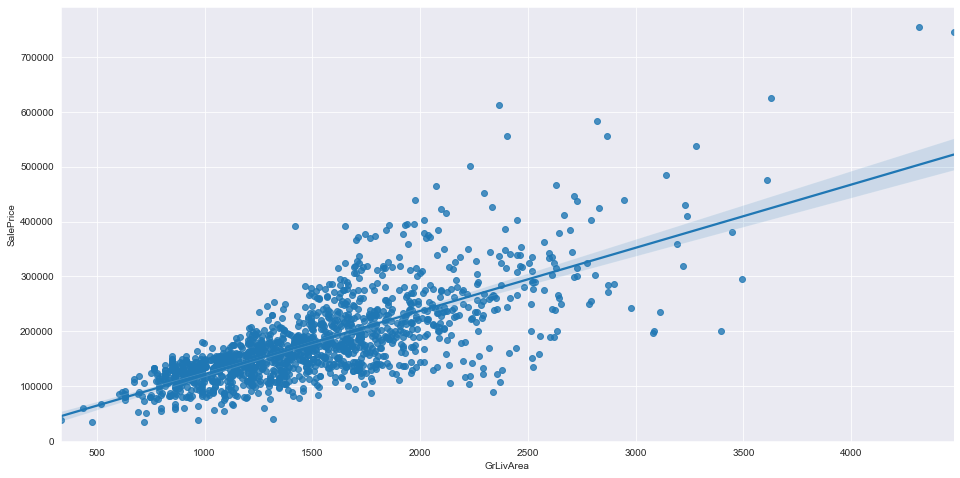

In [115]:
# Removing those two data points
high_GrLivArea = np.where(train_data['GrLivArea'] > 4000)[0]
low_SalePrice = np.where(train_data['SalePrice'] < 200000)[0]

print("high GrLivArea points: ", high_GrLivArea)
print("\nlow SalePrice points: ", low_SalePrice)

outlier_inds = list(set(high_GrLivArea) & set(low_SalePrice))
outlier_inds.sort()

print("\noutliers: ", outlier_inds)

shortened_train_data = train_data.drop(train_data.index[outlier_inds])

plt.figure(figsize=(16,8))
sns.regplot(x=shortened_train_data['GrLivArea'], y=shortened_train_data['SalePrice'])

It looks like removing the two outliers has reduced the spread of our trend and properly handling outliers should be an important step in the analysis. It's important to note that removing outliers is not always safe and should be done with caution. A safer option moving forward should be to make the machine learning model more robust to outliers. Unfortunately, I have not learned this skill yet from the courses so we will not be applying these techniques yet.

<a id="subsec-7b"></a>
## Section 7.b Heatmaps of the Data
There are too many columns of data to individually compare to the SalePrice. Here we will be using a heatmap to see how each property correlates to SalePrice using a Heatmap.

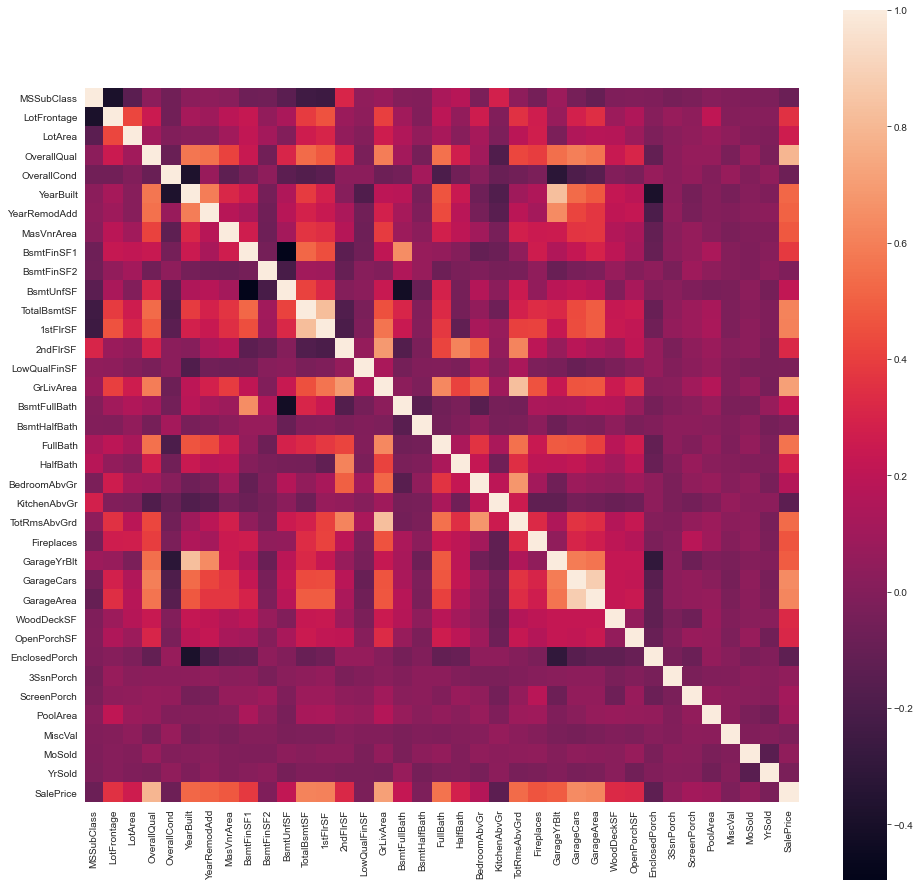

In [116]:
# need to generate a correlation matrix with our data
correlation_matrix = train_data.corr()

plt.figure(figsize=(16,16))
sns.heatmap(correlation_matrix, square=True)

The bottom row is the SalePrice and we can see which properties seem to correlates most strongly with it.
1. OverallQual
2. GrLivArea
These two properties seem to be the strongly correlated but we can fiddle with heatmap properties to find the ones that are most relevant.

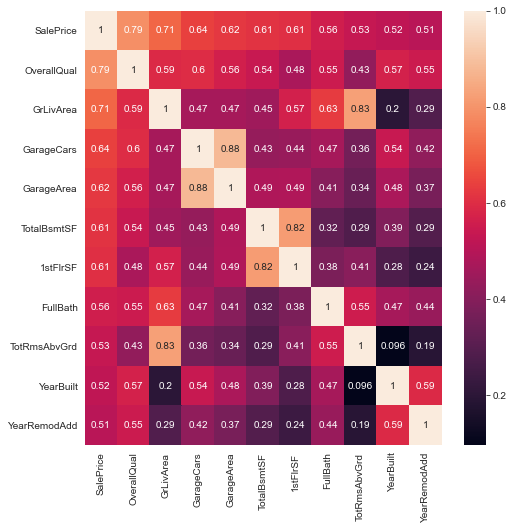

In [117]:
plt.figure(figsize=(8,8))

# look for the top 10 properties, need to pass number of properties we're
# interested + 1 because SalePrice has a 1:1 correlation with itself
num_variables = 11 

top_cols = correlation_matrix.nlargest(num_variables, 'SalePrice')['SalePrice'].index
short_cm = np.corrcoef(train_data[top_cols].values.T)

sns.heatmap(short_cm, annot=True, yticklabels=top_cols.values, xticklabels=top_cols.values)

Doing this we can see in descending order the most important properties are:
1. OverallQual: Rates the overall material and finish of the house
2. GrLivArea: Above grade (ground) living area in square feet
3. GarageCars: Size of garage in car capacity
4. GarageArea: Size of garage in square feet
5. TotalBsmtSF: Total square feet of basement area
6. 1stFlrSF: First Floor square feet
7. FullBath: Full bathrooms above grade
8. TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
9. YearBuilt: Original construction date
10. YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)


In regards to this data we can draw some comparisons between some of them

* GarageCars and GarageArea are effectively describing the same thing.
* TotRmsAbvGrd and GrLivArea are similar and also describe the total space above ground
* There is strong correlation between 1stFlrSF and TotalBsmtSF likely suggesting that if you have a large basement then you'll also have a large ground floor.
* There is effectively no correlation between when the house was built and the total square ft of the home.

<a id="sec-8"></a>
# Part 8. Checking which method is best and saving to submission.csv

In [118]:
print("MAE values generated:")
for i in scores_dict:
    print(i + " : " + str(scores_dict[i]))
    
min_key = min(scores_dict, key=scores_dict.get)

print("\nMethod with lowest MAE:")
print(min_key)

submission = submission_dict[min_key]
# print(submission)

output = pd.DataFrame({'Id': sample_data.Id,
                       'SalePrice': submission})
output.to_csv('submission.csv', index=False)
print("\nOutput generated as submission.csv")

MAE values generated:
1.a : 23523.98780593607
2.a : 17560.328025114155
2.b : 18116.185490867574
2.c : 18072.668013698632
3.a : 17780.382191780824
3.b : 17613.571061643837
3.c : 17612.669006849315
4.a : 17648.417157534244
5.a : 18248.345889801505
6.a : 17662.736729452055
6.b : 16802.965325342466

Method with lowest MAE:
6.b

Output generated as submission.csv
